<img src="images/tennisballbounce1.jpg" alt="Drawing" style="width: 360px;"/><img src="images/rafashot.jpg" alt="Drawing" style="width: 295px;"/>

## ATP Match Study: Inference Analysis

In this notebook, we're looking at the statistical significance of distribution differences between match statistics of winners versus losers (non-winners). This is not testing all of the match statistics; only those that seemed relevant for the model built in the EDA notebook.

In [1]:
import pandas as pd, csv, matplotlib as mlp, matplotlib.pyplot as plt, numpy as np, seaborn as sns, sklearn as sk
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split

In [2]:
# Import Data
results = pd.read_csv('data/result.csv').set_index(['match_id'])

features = ['ace_pct','df_pct','firstsrv_in_pct','firstsrv_won_pct','secondsrv_won_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct']
labels = ['win']

wins = results.loc[results.win == True,:].copy()
nowins = results.loc[results.win == False,:].copy()

In [3]:
# Seed Random
np.random.seed(500)

# Set default for figure sizes
# mlp.rcParams['figure.figsize'] = (10,6)

# Set some sensible display options for data investigation
pd.options.display.max_columns = 40
pd.options.display.max_rows = 500

def bins_rule_of_thumb(data):
    return int(np.sqrt(len(data)))

# Define Comparison Function Difference of Means
def mean_diff(data1,data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Create Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Define function to generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

def test_mean_diff(data1,data2,mean_diff_val,h0_diff=0):
    perm_replicates = draw_perm_reps(data1,data2,mean_diff,10000)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates, color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})


    ## CI_area = perm_replicates[perm_replicates <= CI[0]]
    ## _ = plt.hist(CI_area)

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':0.5,'headwidth':5,'color': 'red'})

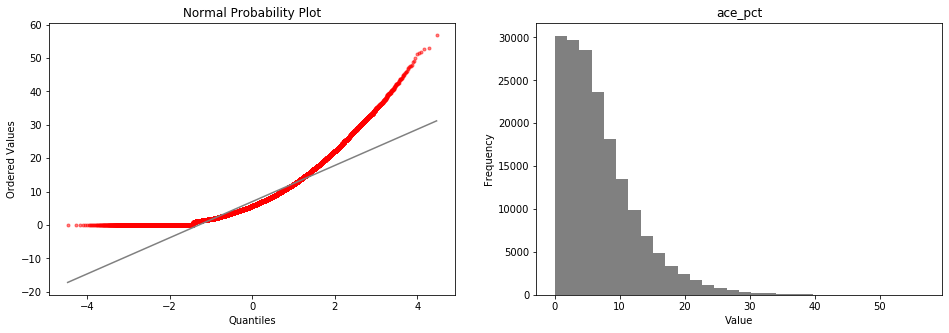

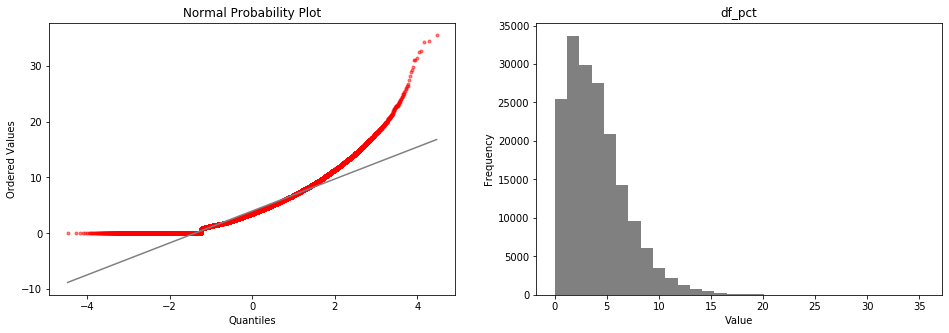

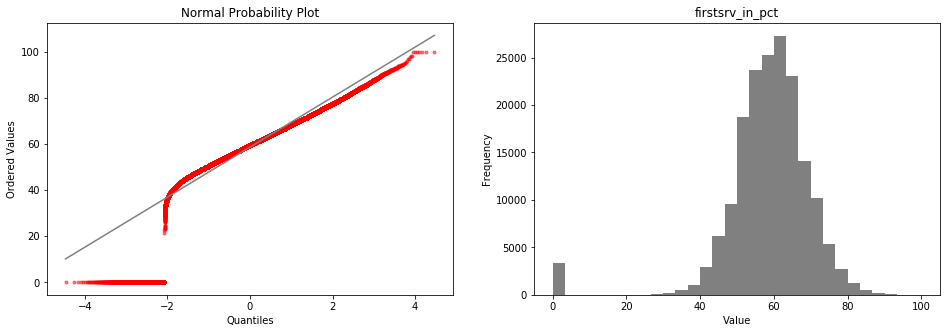

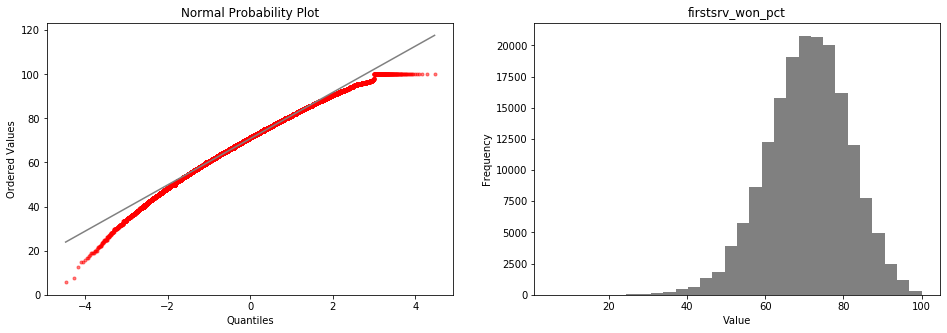

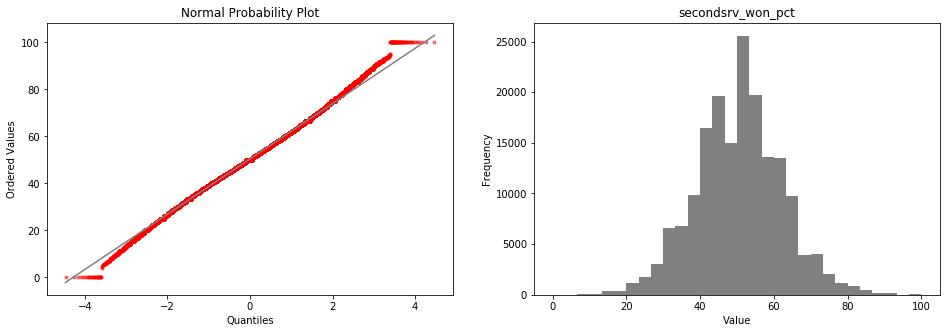

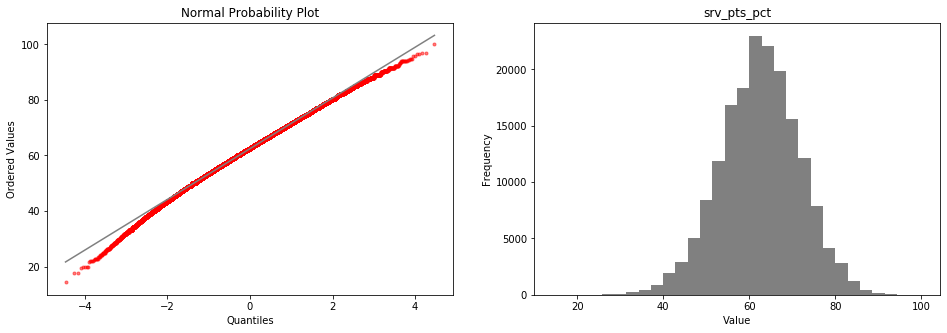

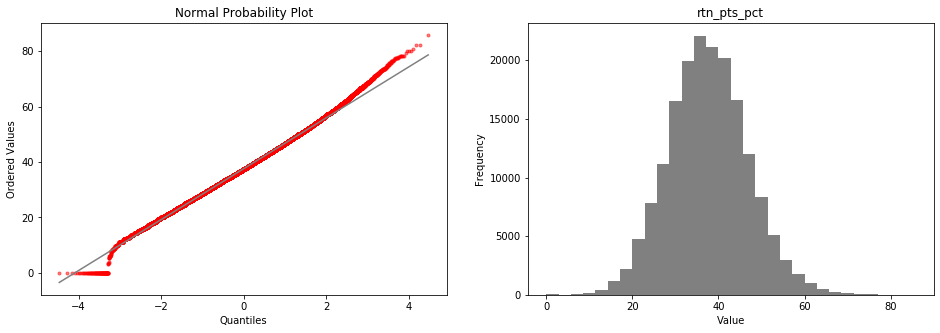

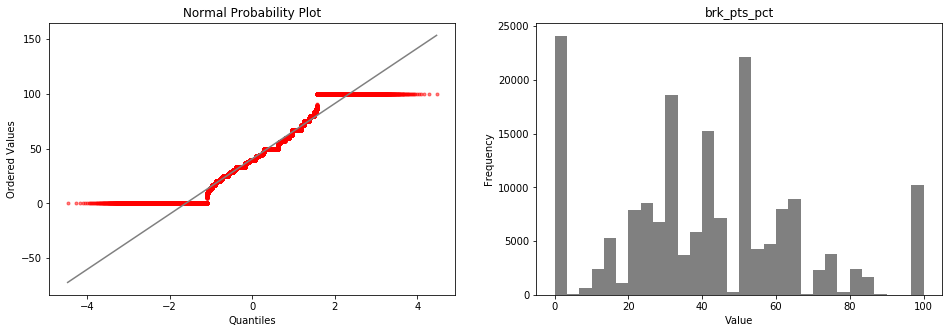

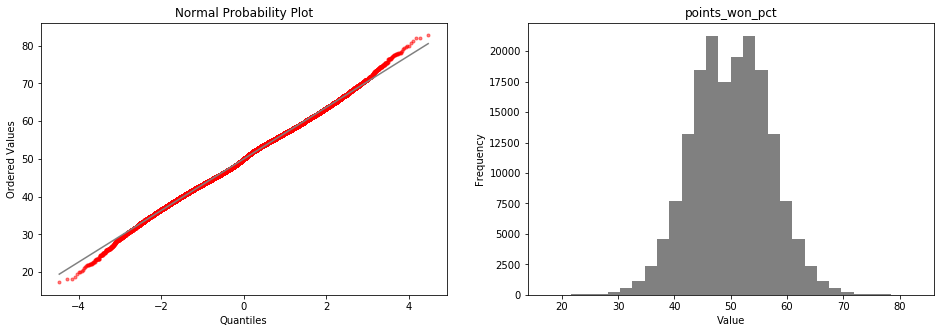

In [4]:
import scipy.stats as stats

def lreg_line(slope,intercept,test_data):
    x_lreg = np.array([min(test_data),max(test_data)])
    y_lreg = slope * x_lreg + intercept
    return x_lreg,y_lreg
        
def qq_plot(data):
    data_no_na = data.dropna()
    fig, ax = plt.subplots(1,2,figsize=(16, 5))
    _ = plt.subplot(1,2,1)
    (x,y), (slope,intercept,r) = stats.probplot(data_no_na, dist="norm", plot=None)
    _ = plt.plot(x,y,marker='.',linestyle='none',color='red',alpha=0.5)
    x_lreg,y_lreg = lreg_line(slope,intercept,x)
    _ = plt.plot(x_lreg,y_lreg,color='gray')
    _ = plt.xlabel('Quantiles')
    _ = plt.ylabel('Ordered Values')
    _ = plt.title('Normal Probability Plot')
    _ = plt.subplot(1,2,2)
    _ = plt.hist(data_no_na, color='gray',bins=30)
    _ = plt.xlabel('Value')
    _ = plt.ylabel('Frequency')

features = ['ace_pct','df_pct','firstsrv_in_pct','firstsrv_won_pct','secondsrv_won_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct']
labels = ['win']

for feature in features:
    qq_plot(results[feature])
    plt.title(feature)

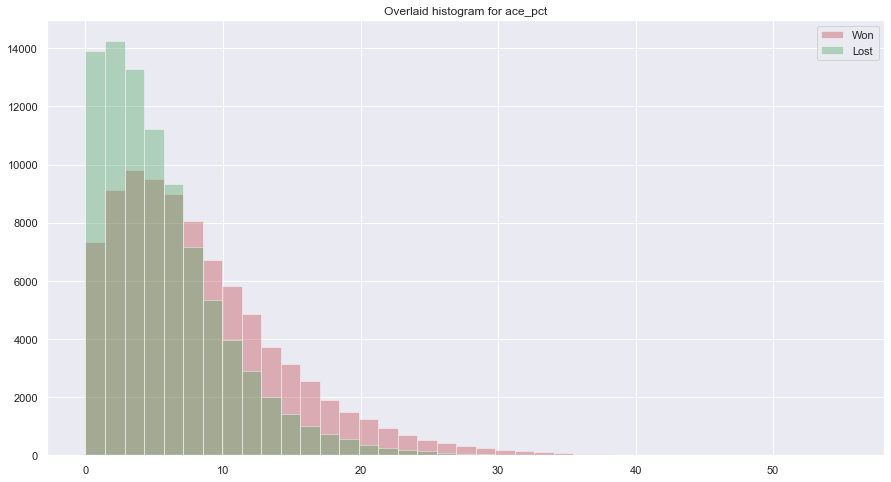

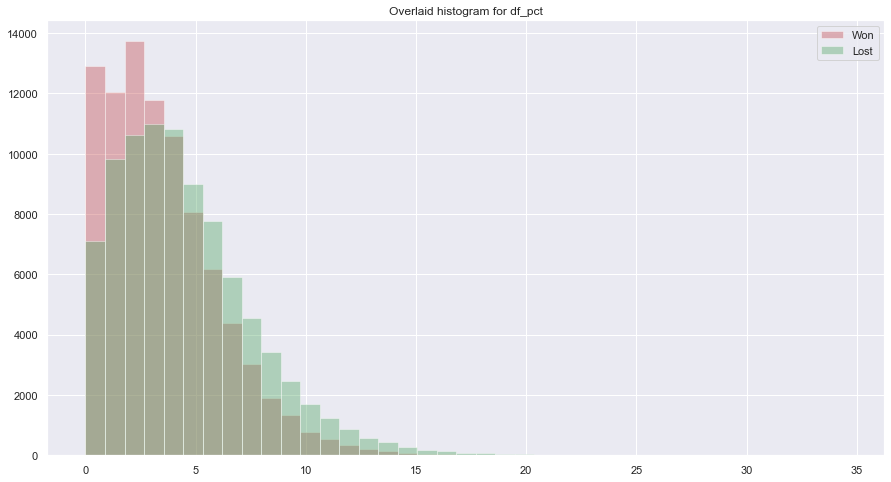

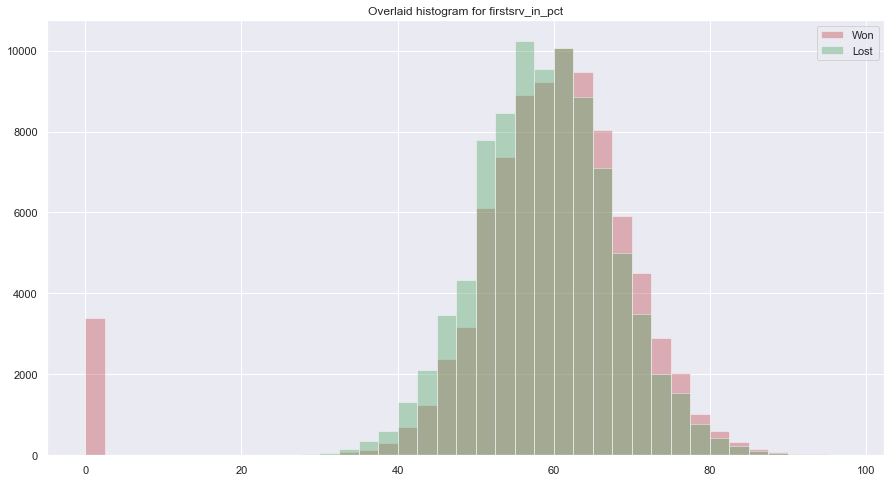

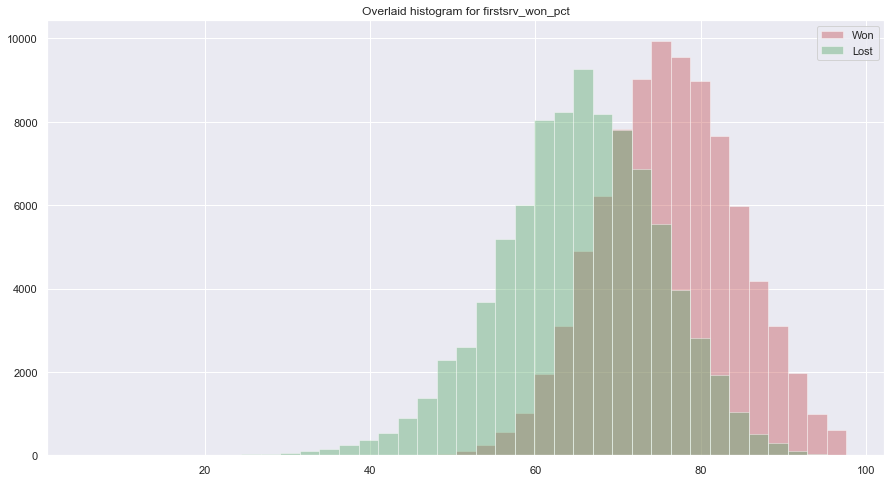

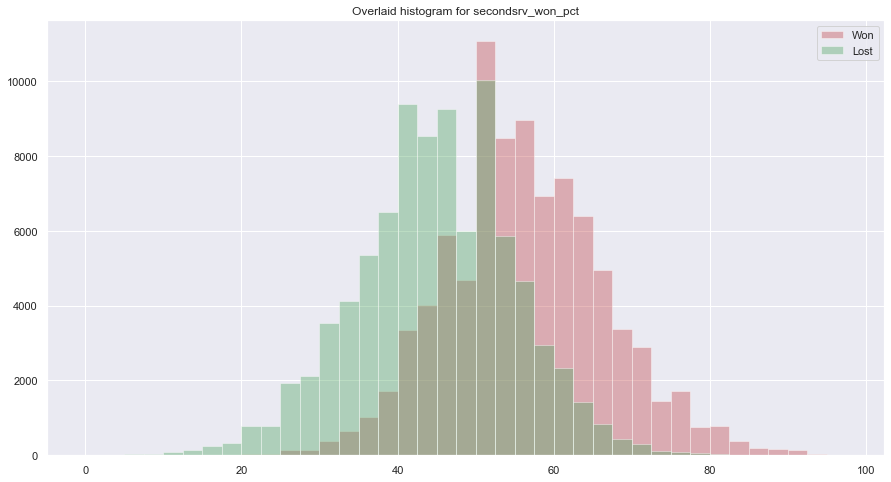

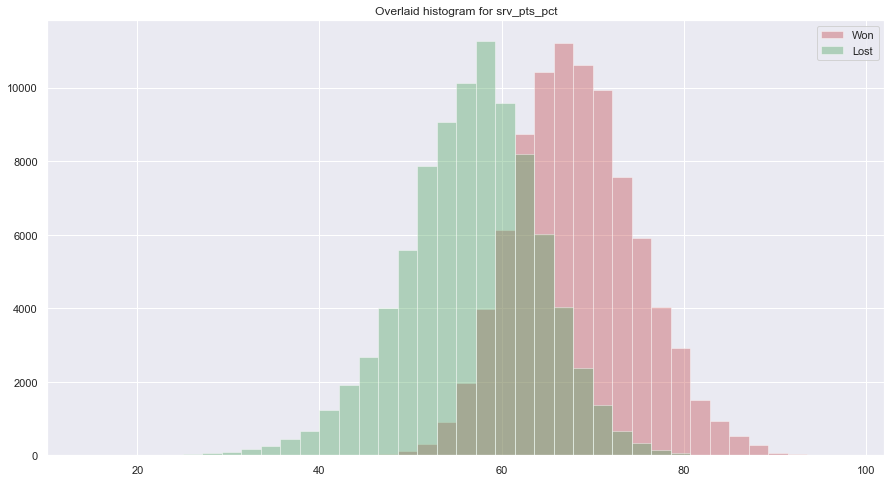

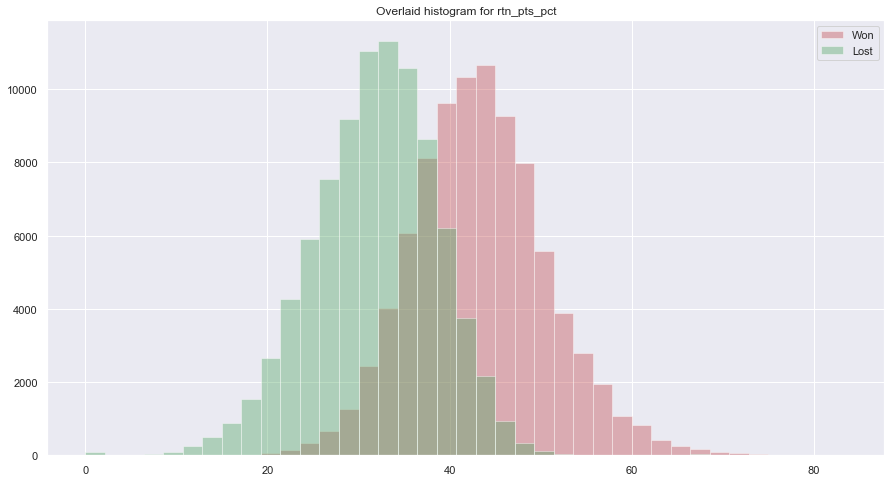

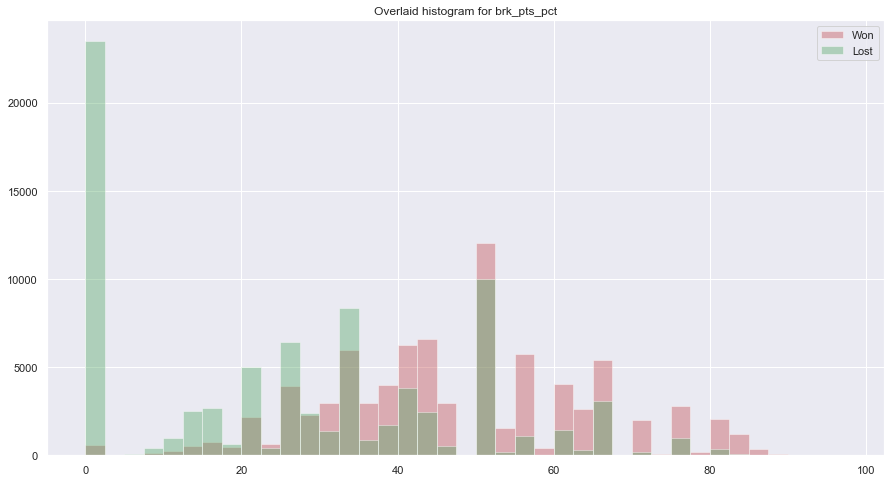

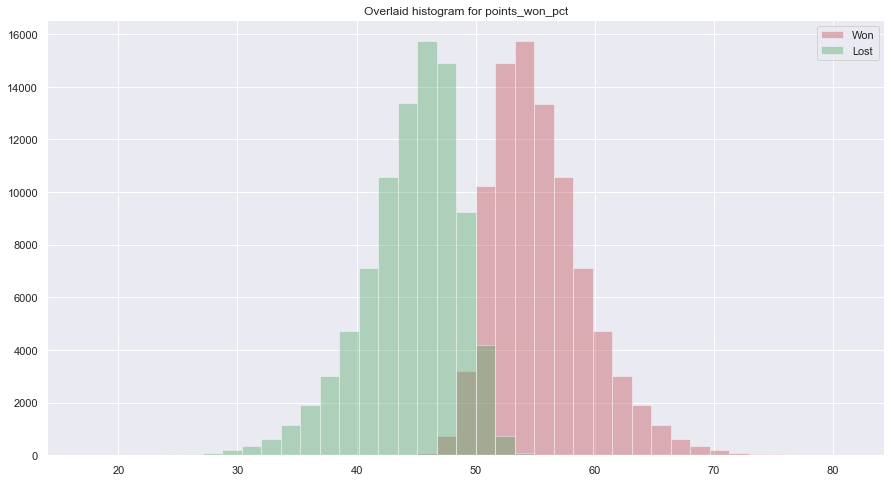

In [5]:
sns.set(color_codes=True)

for i in ['ace_pct','df_pct','firstsrv_in_pct','firstsrv_won_pct','secondsrv_won_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct']:
    plt.figure(figsize=(15,8))
    won = list(results[results['win'] == 1][i])
    lost = list(results[results['win'] == 0][i])
    xmin = min(min(won), min(lost))
    xmax = max(max(won), max(lost))
    width = (xmax - xmin) / 40
    sns.distplot(won, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(lost, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Won','Lost'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()
    # filename = paste("pics/histogramstep3", i, ".png",sep="")
    # plt.savefig(filename)

## Total Points Won Percent Distribution

Wins Mean: 55.467522564258786
No-Wins Mean: 44.53247743574097
Mean Diff: 10.935045128517814
H0 Diff: 0


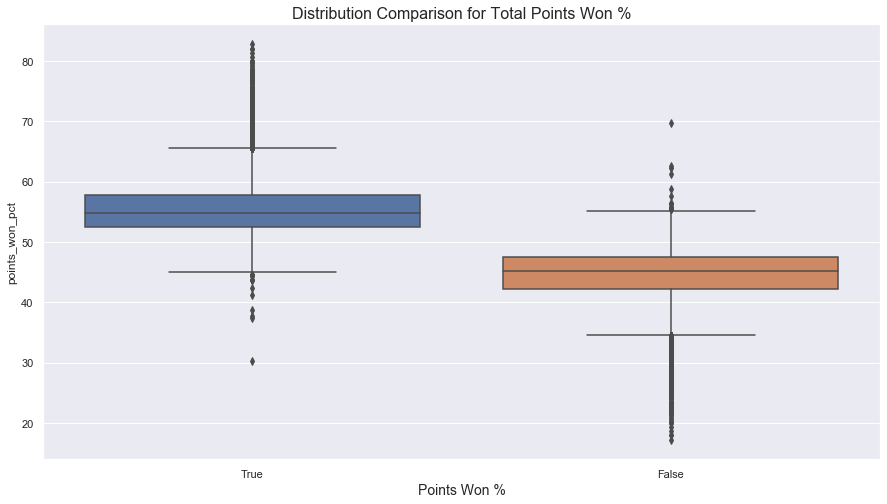

p: 0.0
CI: [-0.06340182  0.06449383]
ME: 0.0643440163767998


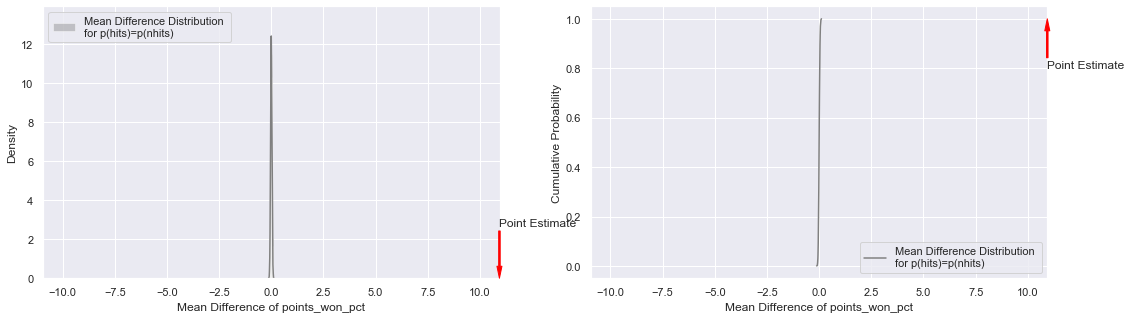

In [6]:
wins_totalpointswonpercent = wins.points_won_pct.dropna()
nowins_totalpointswonpercent = nowins.points_won_pct.dropna()

wins_nowins_diff = wins_totalpointswonpercent.mean() - nowins_totalpointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.points_won_pct.mean(), nowins.points_won_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='points_won_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for Total Points Won %',fontsize=16)
plt.xlabel('Points Won %',fontsize=14)
plt.show()

test_mean_diff(wins_totalpointswonpercent,nowins_totalpointswonpercent,wins_nowins_diff)

## Ace Percent Distribution

Wins Mean: 8.340683934072723
No-Wins Mean: 5.599402213071454
Mean Diff: 2.741281721001269
H0 Diff: 0


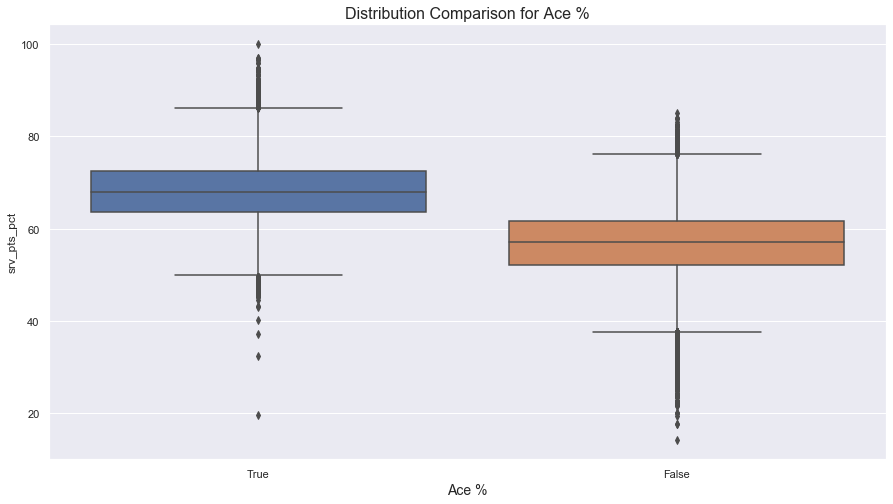

p: 0.0
CI: [-0.05543164  0.05391917]
ME: 0.0542496656889285


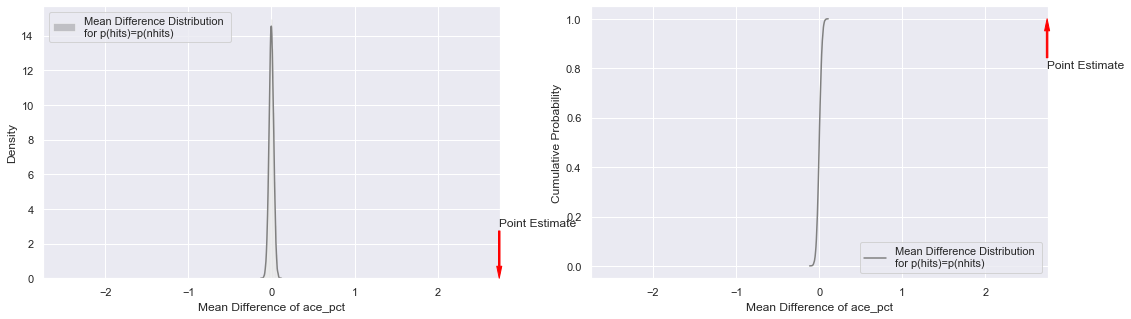

In [7]:
wins_acepercent = wins.ace_pct.dropna()
nowins_acepercent = nowins.ace_pct.dropna()

wins_nowins_diff = wins_acepercent.mean() - nowins_acepercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.ace_pct.mean(), nowins.ace_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='srv_pts_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for Ace %',fontsize=16)
plt.xlabel('Ace %',fontsize=14)
plt.show()

test_mean_diff(wins_acepercent,nowins_acepercent,wins_nowins_diff)

## Double Faults Distribution

Wins Mean: 3.471326834959865
No-Wins Mean: 4.511129954525473
Mean Diff: -1.0398031195656081
H0 Diff: 0


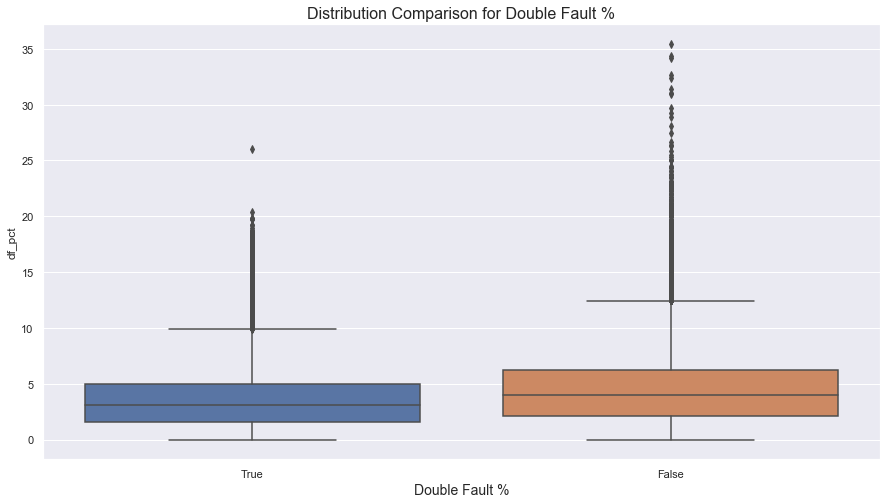

p: 0.0
CI: [-0.02759992  0.02693321]
ME: 0.027101754553074547


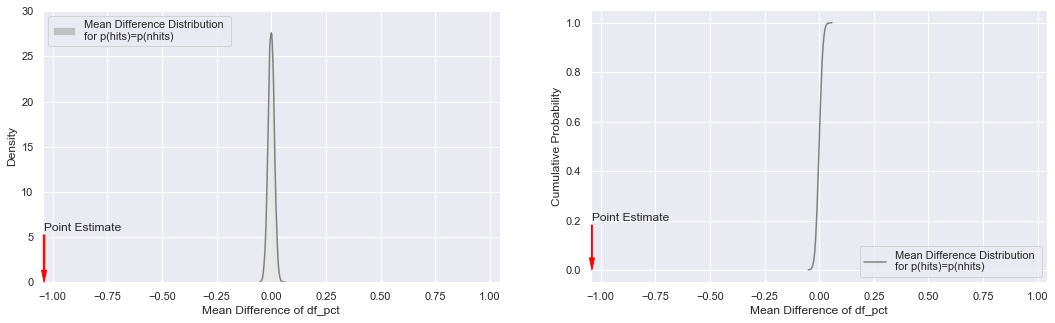

In [8]:
wins_doublefaultspercent = wins.df_pct.dropna()
nowins_doublefaultspercent = nowins.df_pct.dropna()

wins_nowins_diff = wins_doublefaultspercent.mean() - nowins_doublefaultspercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.df_pct.mean(), nowins.df_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='df_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for Double Fault %',fontsize=16)
plt.xlabel('Double Fault %',fontsize=14)
plt.show()

test_mean_diff(wins_doublefaultspercent,nowins_doublefaultspercent,wins_nowins_diff)

## First Serves In % Distribution

Wins Mean: 58.35125231156482
No-Wins Mean: 58.8646494896052
Mean Diff: -1.0398031195656081
H0 Diff: 0


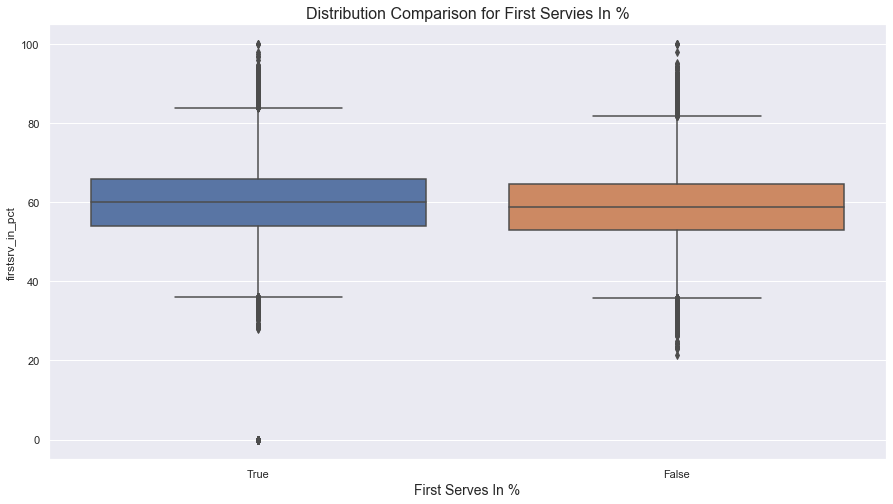

In [ ]:
wins_firstservesinpercent = wins.firstsrv_in_pct.dropna()
nowins_firstservesinpercent = nowins.firstsrv_in_pct.dropna()

wins_nowins_diff = wins_doublefaultspercent.mean() - nowins_doublefaultspercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.firstsrv_in_pct.mean(), nowins.firstsrv_in_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='firstsrv_in_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for First Servies In %',fontsize=16)
plt.xlabel('First Serves In %',fontsize=14)
plt.show()

test_mean_diff(wins_firstservesinpercent,nowins_firstservesinpercent,wins_nowins_diff)

## First Serves Won % Distribution

In [ ]:
wins_firstserveswonpercent = wins.firstsrv_won_pct.dropna()
nowins_firstserveswonpercent = nowins.firstsrv_won_pct.dropna()

wins_nowins_diff = wins_firstserveswonpercent.mean() - nowins_firstserveswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.firstsrv_won_pct.mean(), nowins.firstsrv_won_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='firstsrv_won_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for First Servies Won %',fontsize=16)
plt.xlabel('First Serves Won %',fontsize=14)
plt.show()

test_mean_diff(wins_firstserveswonpercent,nowins_firstserveswonpercent,wins_nowins_diff)

## Second Serves Won % Distribution

In [ ]:
wins_secondserveswonpercent = wins.secondsrv_won_pct.dropna()
nowins_secondserveswonpercent = nowins.secondsrv_won_pct.dropna()

wins_nowins_diff = wins_secondserveswonpercent.mean() - nowins_secondserveswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.secondsrv_won_pct.mean(), nowins.secondsrv_won_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='secondsrv_won_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for Second Serves Won %',fontsize=16)
plt.xlabel('Second Serves Won %',fontsize=14)
plt.show()

test_mean_diff(wins_secondserveswonpercent,nowins_secondserveswonpercent,wins_nowins_diff)

## Serve Points Won Distribution

In [ ]:
wins_servepointswonpercent = wins.srv_pts_pct.dropna()
nowins_servepointswonpercent = nowins.srv_pts_pct.dropna()

wins_nowins_diff = wins_servepointswonpercent.mean() - nowins_servepointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.srv_pts_pct.mean(), nowins.srv_pts_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='srv_pts_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for Serves Points Won %',fontsize=16)
plt.xlabel('Second Serve Points Won %',fontsize=14)
plt.show()

test_mean_diff(wins_servepointswonpercent,nowins_servepointswonpercent,wins_nowins_diff)

## Return Points Won Percent Distribution

In [ ]:
wins_returnpointswonpercent = wins.rtn_pts_pct.dropna()
nowins_returnpointswonpercent = nowins.rtn_pts_pct.dropna()

wins_nowins_diff = wins_returnpointswonpercent.mean() - nowins_returnpointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.rtn_pts_pct.mean(), nowins.rtn_pts_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='rtn_pts_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for Return Points Won %',fontsize=16)
plt.xlabel('Second Return Points Won %',fontsize=14)
plt.show()

test_mean_diff(wins_returnpointswonpercent,nowins_returnpointswonpercent,wins_nowins_diff)

## Break Points Won Percent Distribution

In [ ]:
wins_breakpointswonpercent = wins.brk_pts_pct.dropna()
nowins_breakpointswonpercent = nowins.brk_pts_pct.dropna()

wins_nowins_diff = wins_breakpointswonpercent.mean() - nowins_breakpointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.brk_pts_pct.mean(), nowins.brk_pts_pct.mean(), wins_nowins_diff,h0_diff))

plt.figure(figsize=(15,8))
sns.boxplot(x='win',y='brk_pts_pct',data=results,order=[True,False])
plt.title('Distribution Comparison for Break Points Won %',fontsize=16)
plt.xlabel('Second Break Points Won %',fontsize=14)
plt.show()

test_mean_diff(wins_breakpointswonpercent,nowins_breakpointswonpercent,wins_nowins_diff)